# Imports

In [1]:
import os
import librosa
import librosa.display
import cgi
import json
import sys
import time

import numpy as np
import pandas as pd
import IPython as ipd
import plotly.express as px
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from dotenv import load_dotenv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter, SUPPRESS
from urllib.parse import quote, unquote, urlencode
from urllib.request import urlopen, Request


/var/folders/0k/kjgc3b_144n54tq57syzl08r0000gn/T/ipykernel_80886/34209564.py:4: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [ ]:
def analyze_timbre_to_dataframe_all_frames(audio_path: str, n_mfcc: int = 13):
    """
    Gets features to analyze vocal timbre per frame
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # print(spectral_centroid)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # print(spectral_rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)[0]
    # print(zero_crossing_rate)

    # transpose to get frames as rows
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T

    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T

    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)

    tempo, _ = librosa.beat.beat_track(onset_envelope=spectral_flux, sr=sr)

    data = {
        "frame": np.arange(len(spectral_centroid)),
        "spectral_centroid": spectral_centroid,
        "spectral_rolloff": spectral_rolloff,
        "zero_crossing_rate": zero_crossing_rate,
        "tempo": [tempo] * len(spectral_centroid)
    }

    # add MFCCs and Chroma to dictionary
    for i in range(n_mfcc):
        data[f"mfcc_{i+1}"] = mfcc[:, i]

    for i in range(chroma.shape[1]):
        data[f"chroma_{i+1}"] = chroma[:, i]

    df = pd.DataFrame(data)

    df["spectral_flux"] = spectral_flux[:len(df)]

    return df



In [20]:
def analyze_timbre_to_dataframe_w_avgs(audio_path: str, n_mfcc: int = 13):
    """
    Gets features to analyze vocal timbre by averaging features across every frame
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # print(spectral_centroid)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # print(spectral_rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)[0]
    # print(zero_crossing_rate)

    # transpose to get frames as rows
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T

    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T

    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)

    # tempo, _ = librosa.beat.beat_track(onset_envelope=spectral_flux, sr=sr)

    features = {
        # "artist": [audio_path],
        "mfcc": [np.mean(mfcc)],
        "spectral_centroid": [np.mean(spectral_centroid)],
        "spectral_flux": [np.mean(spectral_flux)],
        "spectral_rolloff": [np.mean(spectral_rolloff)],
        "zero_crossing_rate": [np.mean(zero_crossing_rate)],
        "chroma": [np.mean(chroma)]
    }

    # flatten the dictionary into a single vector of features
    feature_vector = np.concatenate(list(features.values()))

    return feature_vector

# Vocal Analysis 1
- Uses the source separation output from yt_download_and_source_separation project

In [106]:
DATA_DIR = Path("data")

file_paths = []
for file in os.listdir(DATA_DIR):
    if file == ".DS_Store":
        continue

    print(file)
    file_paths.append(file)

Beyonce2_foreground_vocals.wav
Adele2_foreground_vocals.wav
Beyonce_foreground_vocals.wav
SZA2_foreground_vocals.wav
Adele_foreground_vocals.wav
Whitney_foreground_vocals.wav
SZA_foreground_vocals.wav
Adele3_foreground_vocals.wav
Beyonce3_foreground_vocals.wav
SZA3_foreground_vocals.wav


In [ ]:
all_features = []

for filename in file_paths:
    feature_vector = analyze_timbre_to_dataframe_w_avgs(audio_path= DATA_DIR / filename)
    all_features.append(feature_vector)

# convert features to dataframe
df = pd.DataFrame(all_features, columns=["mfcc", "spectral_centroid", "spectral_flux", "spectral_rolloff", "zero_crossing_rate", "chroma"])

In [108]:
df

,mfcc,spectral_centroid,spectral_flux,spectral_rolloff,zero_crossing_rate,chroma
0,-34.312157,2653.938743,1.926958,4675.296142,0.176231,0.220311
1,-30.286701,2910.580579,1.250553,5102.326068,0.195042,0.232074
2,-30.743858,2668.087934,1.826119,4572.908026,0.179440,0.215246
3,-29.948076,2321.220770,1.653840,4065.307617,0.144988,0.236145
4,-32.762814,2786.458281,1.566974,4890.332206,0.187471,0.245257
5,-35.025097,3100.703520,1.460531,5579.677736,0.217537,0.229565
6,-34.506031,3265.172909,2.070094,5447.723202,0.214386,0.246258
7,-33.216553,3728.627196,1.953180,6641.234590,0.254670,0.224063
8,-35.997620,3003.008862,1.526667,5275.528000,0.201072,0.230362
9,-28.508251,2459.797850,1.866456,4309.297239,0.152411,0.227733


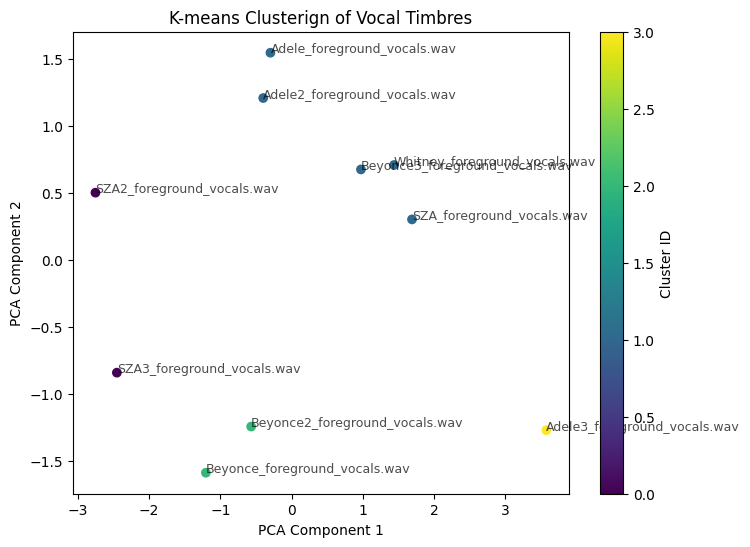

In [109]:
# standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# k means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(df_scaled)

# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df["cluster"], cmap="viridis", marker="o")
plt.title("K-means Clusterign of Vocal Timbres")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

for i, filename in enumerate(file_paths):
    plt.annotate(filename, (df_pca[i, 0], df_pca[i, 1]), fontsize=9, alpha=0.7)

plt.colorbar(label="Cluster ID")

plt.show()

In [113]:
df.loc[:, "arist"] = file_paths

In [114]:
df

,mfcc,spectral_centroid,spectral_flux,spectral_rolloff,zero_crossing_rate,chroma,cluster,arist
0,-34.312157,2653.938743,1.926958,4675.296142,0.176231,0.220311,2,Beyonce2_foreground_vocals.wav
1,-30.286701,2910.580579,1.250553,5102.326068,0.195042,0.232074,1,Adele2_foreground_vocals.wav
2,-30.743858,2668.087934,1.826119,4572.908026,0.179440,0.215246,2,Beyonce_foreground_vocals.wav
3,-29.948076,2321.220770,1.653840,4065.307617,0.144988,0.236145,0,SZA2_foreground_vocals.wav
4,-32.762814,2786.458281,1.566974,4890.332206,0.187471,0.245257,1,Adele_foreground_vocals.wav
5,-35.025097,3100.703520,1.460531,5579.677736,0.217537,0.229565,1,Whitney_foreground_vocals.wav
6,-34.506031,3265.172909,2.070094,5447.723202,0.214386,0.246258,1,SZA_foreground_vocals.wav
7,-33.216553,3728.627196,1.953180,6641.234590,0.254670,0.224063,3,Adele3_foreground_vocals.wav
8,-35.997620,3003.008862,1.526667,5275.528000,0.201072,0.230362,1,Beyonce3_foreground_vocals.wav
9,-28.508251,2459.797850,1.866456,4309.297239,0.152411,0.227733,0,SZA3_foreground_vocals.wav


# Vocal Analysis 2:
- Use source separation from LALA.AI (better quality)

In [18]:
DATA_DIR = Path("data/lala_source_separation")

file_paths = []
for file in os.listdir(DATA_DIR):
    if file in [".DS_Store", "separations"]:
        continue

    print(file)
    file_paths.append(file)

Adele_3.mp3
Adele_2.mp3
Beyonce_1.mp3
Beyonce_3.mp3
Adele_1.mp3
Beyonce_2.mp3
Whitney_1.mp3
SZA_1.mp3
SZA_3.mp3
SZA_2.mp3


In [28]:
all_features = []

for filename in file_paths:
    feature_vector = analyze_timbre_to_dataframe_w_avgs(audio_path= DATA_DIR / filename)
    all_features.append(feature_vector)

# convert features to dataframe
lala_df = pd.DataFrame(all_features, columns=["mfcc", "spectral_centroid", "spectral_flux", "spectral_rolloff", "zero_crossing_rate", "chroma"])

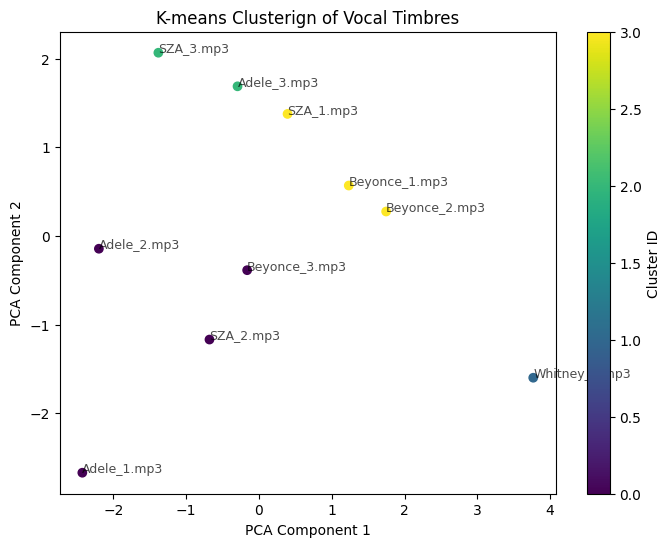

In [29]:
# standardize features
scaler = StandardScaler()
lala_df_scaled = scaler.fit_transform(lala_df)

# k means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
lala_df["cluster"] = kmeans.fit_predict(lala_df_scaled)

# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
lala_df_pca = pca.fit_transform(lala_df_scaled)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(lala_df_pca[:, 0], lala_df_pca[:, 1], c=lala_df["cluster"], cmap="viridis", marker="o")
plt.title("K-means Clusterign of Vocal Timbres")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

for i, filename in enumerate(file_paths):
    plt.annotate(filename, (lala_df_pca[i, 0], lala_df_pca[i, 1]), fontsize=9, alpha=0.7)

plt.colorbar(label="Cluster ID")

plt.show()

In [30]:
lala_df.loc[:, "arist"] = file_paths

In [31]:
lala_df

,mfcc,spectral_centroid,spectral_flux,spectral_rolloff,zero_crossing_rate,chroma,cluster,arist
0,5.141820,2245.678402,1.309928,4733.171709,0.047287,0.408692,2,Adele_3.mp3
1,2.721588,1917.254692,0.944166,3993.972439,0.040963,0.386003,0,Adele_2.mp3
2,4.770776,3063.247238,1.206046,7019.795329,0.060786,0.394139,3,Beyonce_1.mp3
3,2.534003,2612.747564,1.106905,5682.180884,0.057938,0.354186,0,Beyonce_3.mp3
4,-5.198117,1993.058306,0.921758,3812.075337,0.047215,0.294279,0,Adele_1.mp3
5,2.645416,3247.078638,1.205496,6892.305690,0.074191,0.424574,3,Beyonce_2.mp3
6,-2.326364,4052.639226,1.214199,8263.470691,0.110904,0.400765,1,Whitney_1.mp3
7,0.412067,2608.916714,1.231859,5657.385210,0.046212,0.502474,3,SZA_1.mp3
8,5.257668,1946.805442,1.172352,4052.031028,0.033346,0.465073,2,SZA_3.mp3
9,-1.784864,2525.859328,1.055196,5343.012423,0.051006,0.358971,0,SZA_2.mp3
